## Face Recognition using OpenFace

## Steps 
- Enrollment
- Testing
- Inference

In [21]:
import os,sys
import dlib
import cv2
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
import _pickle as cPickle
from dataPath import DATA_PATH
%matplotlib inline

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'


In [23]:
# Path to landmarks and face recognition model files
facerecModelPath = DATA_PATH + "/dlap_week4/models/openface.nn4.small2.v1.t7"
recModel = cv2.dnn.readNetFromTorch(facerecModelPath)
recMean = [0,0,0]
recSize = (96, 96)
recScale = 1/255.0

# Initialize face detector
faceDetector = dlib.get_frontal_face_detector()
PREDICTOR_PATH = DATA_PATH + "/models/shape_predictor_5_face_landmarks.dat"
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [24]:
# Now let's prepare our training data
# data is organized assuming following structure
# faces folder has subfolders.
# each subfolder has images of a person
faceDatasetFolder = DATA_PATH + 'dlap_week4/images/faces'

# read subfolders in folder "faces"
subfolders = []
for x in os.listdir(faceDatasetFolder):
  xpath = os.path.join(faceDatasetFolder, x)
  if os.path.isdir(xpath):
    subfolders.append(xpath)

# nameLabelMap is dict with keys as person's name
# and values as integer label assigned to this person
# labels contain integer labels 
# for corresponding image in imagePaths
nameLabelMap = {}
labels = []
imagePaths = []
for i, subfolder in enumerate(subfolders):
  for x in os.listdir(subfolder):
    xpath = os.path.join(subfolder, x)
    if x.endswith('jpg'):
      imagePaths.append(xpath)
      labels.append(i)
      nameLabelMap[xpath] = subfolder.split('/')[-1]

### Enrolment

In [25]:
# Process images one by one
# We will store face descriptors in an ndarray (faceDescriptors)
# and their corresponding labels in dictionary (index)
index = {}
i = 0
faceDescriptors = None
for imagePath in imagePaths:
  print("processing: {}".format(imagePath))
  # read image and convert it to RGB
  img = cv2.imread(imagePath)

  # detect faces in image
  faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  print("{} Face(s) found".format(len(faces)))

  # Now process each face we found
  for k, face in enumerate(faces):

    alignedFace = fbc.alignFace(img, face, landmarkDetector, recSize)

    # Compute face descriptor using OpenFace network.
    # It is a 128D vector that describes the face.
    blob = cv2.dnn.blobFromImage(alignedFace, recScale, recSize, recMean, False, False)
    recModel.setInput(blob)
    faceDescriptor = recModel.forward()

    # Stack face descriptors (1x128) for each face in images, as rows
    if faceDescriptors is None:
      faceDescriptors = faceDescriptor
    else:
      faceDescriptors = np.concatenate((faceDescriptors, faceDescriptor), axis=0)

    # save the label for this face in index. We will use it later to identify
    # person name corresponding to face descriptors stored in NumPy Array
    index[i] = nameLabelMap[imagePath]
    i += 1

processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/intro_000007.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/intro_000103.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/making_000319.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/satya_making_004377.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/making_003991.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/satya_making_004146.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/Study/LearnOpenCV/src/res/opencv-courses/dlap_week4/images/faces/satya/satya_making_004208.jpg
1 Face(s) found
processing: /Users/iqbal/Iqbal/S

In [26]:
# Write descriors and index to disk
np.save('descriptors_openface.npy', faceDescriptors)
# index has image paths in same order
#  as descriptors in faceDescriptors
with open('index_openface.pkl', 'wb') as f:
  cPickle.dump(index, f)

## Testing

In [27]:
facerecModelPath = DATA_PATH + 'dlap_week4/models/openface.nn4.small2.v1.t7'
recModel = cv2.dnn.readNetFromTorch(facerecModelPath)
recMean = [0,0,0]
recSize = (96, 96)
recScale = 1/255.0
recThreshold = 0.8


# Initialize face detector
faceDetector = dlib.get_frontal_face_detector()
PREDICTOR_PATH = DATA_PATH + "models/shape_predictor_5_face_landmarks.dat"
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# load descriptors and index file generated during enrollment
index = np.load('index_openface.pkl',allow_pickle = True)
faceDescriptorsEnrolled = np.load('descriptors_openface.npy')

In [28]:
imagePath = DATA_PATH + 'dlap_week4/images/faces/satya_demo.jpg'
im = cv2.imread(imagePath, cv2.IMREAD_COLOR)

# exit if unable to read frame from feed
if im is None:
  print ('cannot read image')

In [29]:
faces = faceDetector(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

print("{} Face(s) found".format(len(faces)))

1 Face(s) found


## Inference

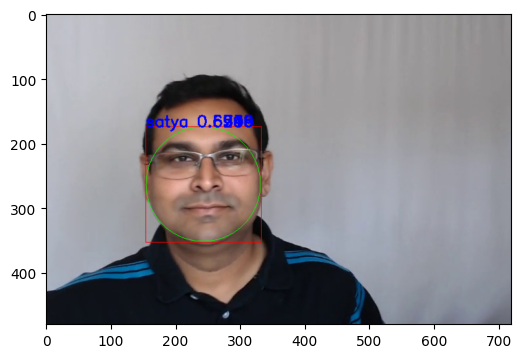

In [33]:
for face in faces:

  # find coordinates of face rectangle
  x1 = face.left()
  y1 = face.top()
  x2 = face.right()
  y2 = face.bottom()

  alignedFace = fbc.alignFace(im, face, 
                              landmarkDetector, 
                              recSize)

  # Compute face descriptor using neural network 
  # defined in Dlib.
  # It is a 128D vector 
  # that describes the face in img identified 
  # by shape.
  blob = cv2.dnn.blobFromImage(alignedFace, recScale, 
                               recSize, recMean, 
                               False, False)
  recModel.setInput(blob)
  faceDescriptorQuery = recModel.forward()


  # Calculate Euclidean distances between face descriptor 
  # calculated on face dectected
  # in current frame with all the face descriptors 
  # we calculated while enrolling faces
  distances = np.linalg.norm(faceDescriptorsEnrolled - 
              faceDescriptorQuery, axis=1)
  # Calculate minimum distance and index of this face
  argmin = np.argmin(distances)  # index
  minDistance = distances[argmin]  # minimum distance

  # If minimum distance if less than threshold
  # find the name of person from index
  # else the person in query image is unknown
  if minDistance <= recThreshold:
    label = index[argmin]
  else:
    label = 'unknown'

  # Draw a rectangle for detected face
  cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255))

  # Draw circle for face recognition
  center = (int((x1 + x2)/2.0), int((y1 + y2)/2.0))
  radius = int((y2-y1)/2.0)
  color = (0, 255, 0)
  cv2.circle(im, center, 
             radius, color, 
             thickness=1, lineType=8, 
             shift=0)

  # Write test on image specifying identified person 
  # and minimum distance
  # bottom left corner of text string
  org = (int(x1), int(y1))  
  font_face = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.8
  text_color = (255, 0, 0)
  printLabel = '{} {:0.4f}'.format(label, minDistance)
  cv2.putText(im, printLabel, org, font_face, font_scale, 
              text_color, thickness=2)
  
  # Show result
plt.imshow(im[:,:,::-1])
plt.show()